<a href="https://colab.research.google.com/github/mainabhihoon/simp_learn_repos/blob/main/Sales_Analysis_Report_(Q4_2020).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data Wrangling and Preparation

### Initial Data Load and Inspection
| Date       | Time      | State   | Group   |   Unit |   Sales |
|:-----------|:----------|:--------|:--------|-------:|--------:|
| 1-Oct-2020 | Morning   | WA      | Kids    |      8 |   20000 |
| 1-Oct-2020 | Morning   | WA      | Men     |      8 |   20000 |
| 1-Oct-2020 | Morning   | WA      | Women   |      4 |   10000 |
| 1-Oct-2020 | Morning   | WA      | Seniors |     15 |   37500 |
| 1-Oct-2020 | Afternoon | WA      | Kids    |      3 |    7500 |

Total Records: 7560

### 1.a. Missing Data Inspection
**Result:** No missing values found. `df.isna().sum().sum()` is **0**.

### 1.b. Recommendations for Treating Missing and Incorrect Data

* **Missing Data:** Since the dataset has no null values, no treatment is required. However, in a real-world scenario, for the small missing data found (<5%), **row-wise deletion** (dropping nulls) for the sake of simplicity and avoiding imputation bias is recommended.


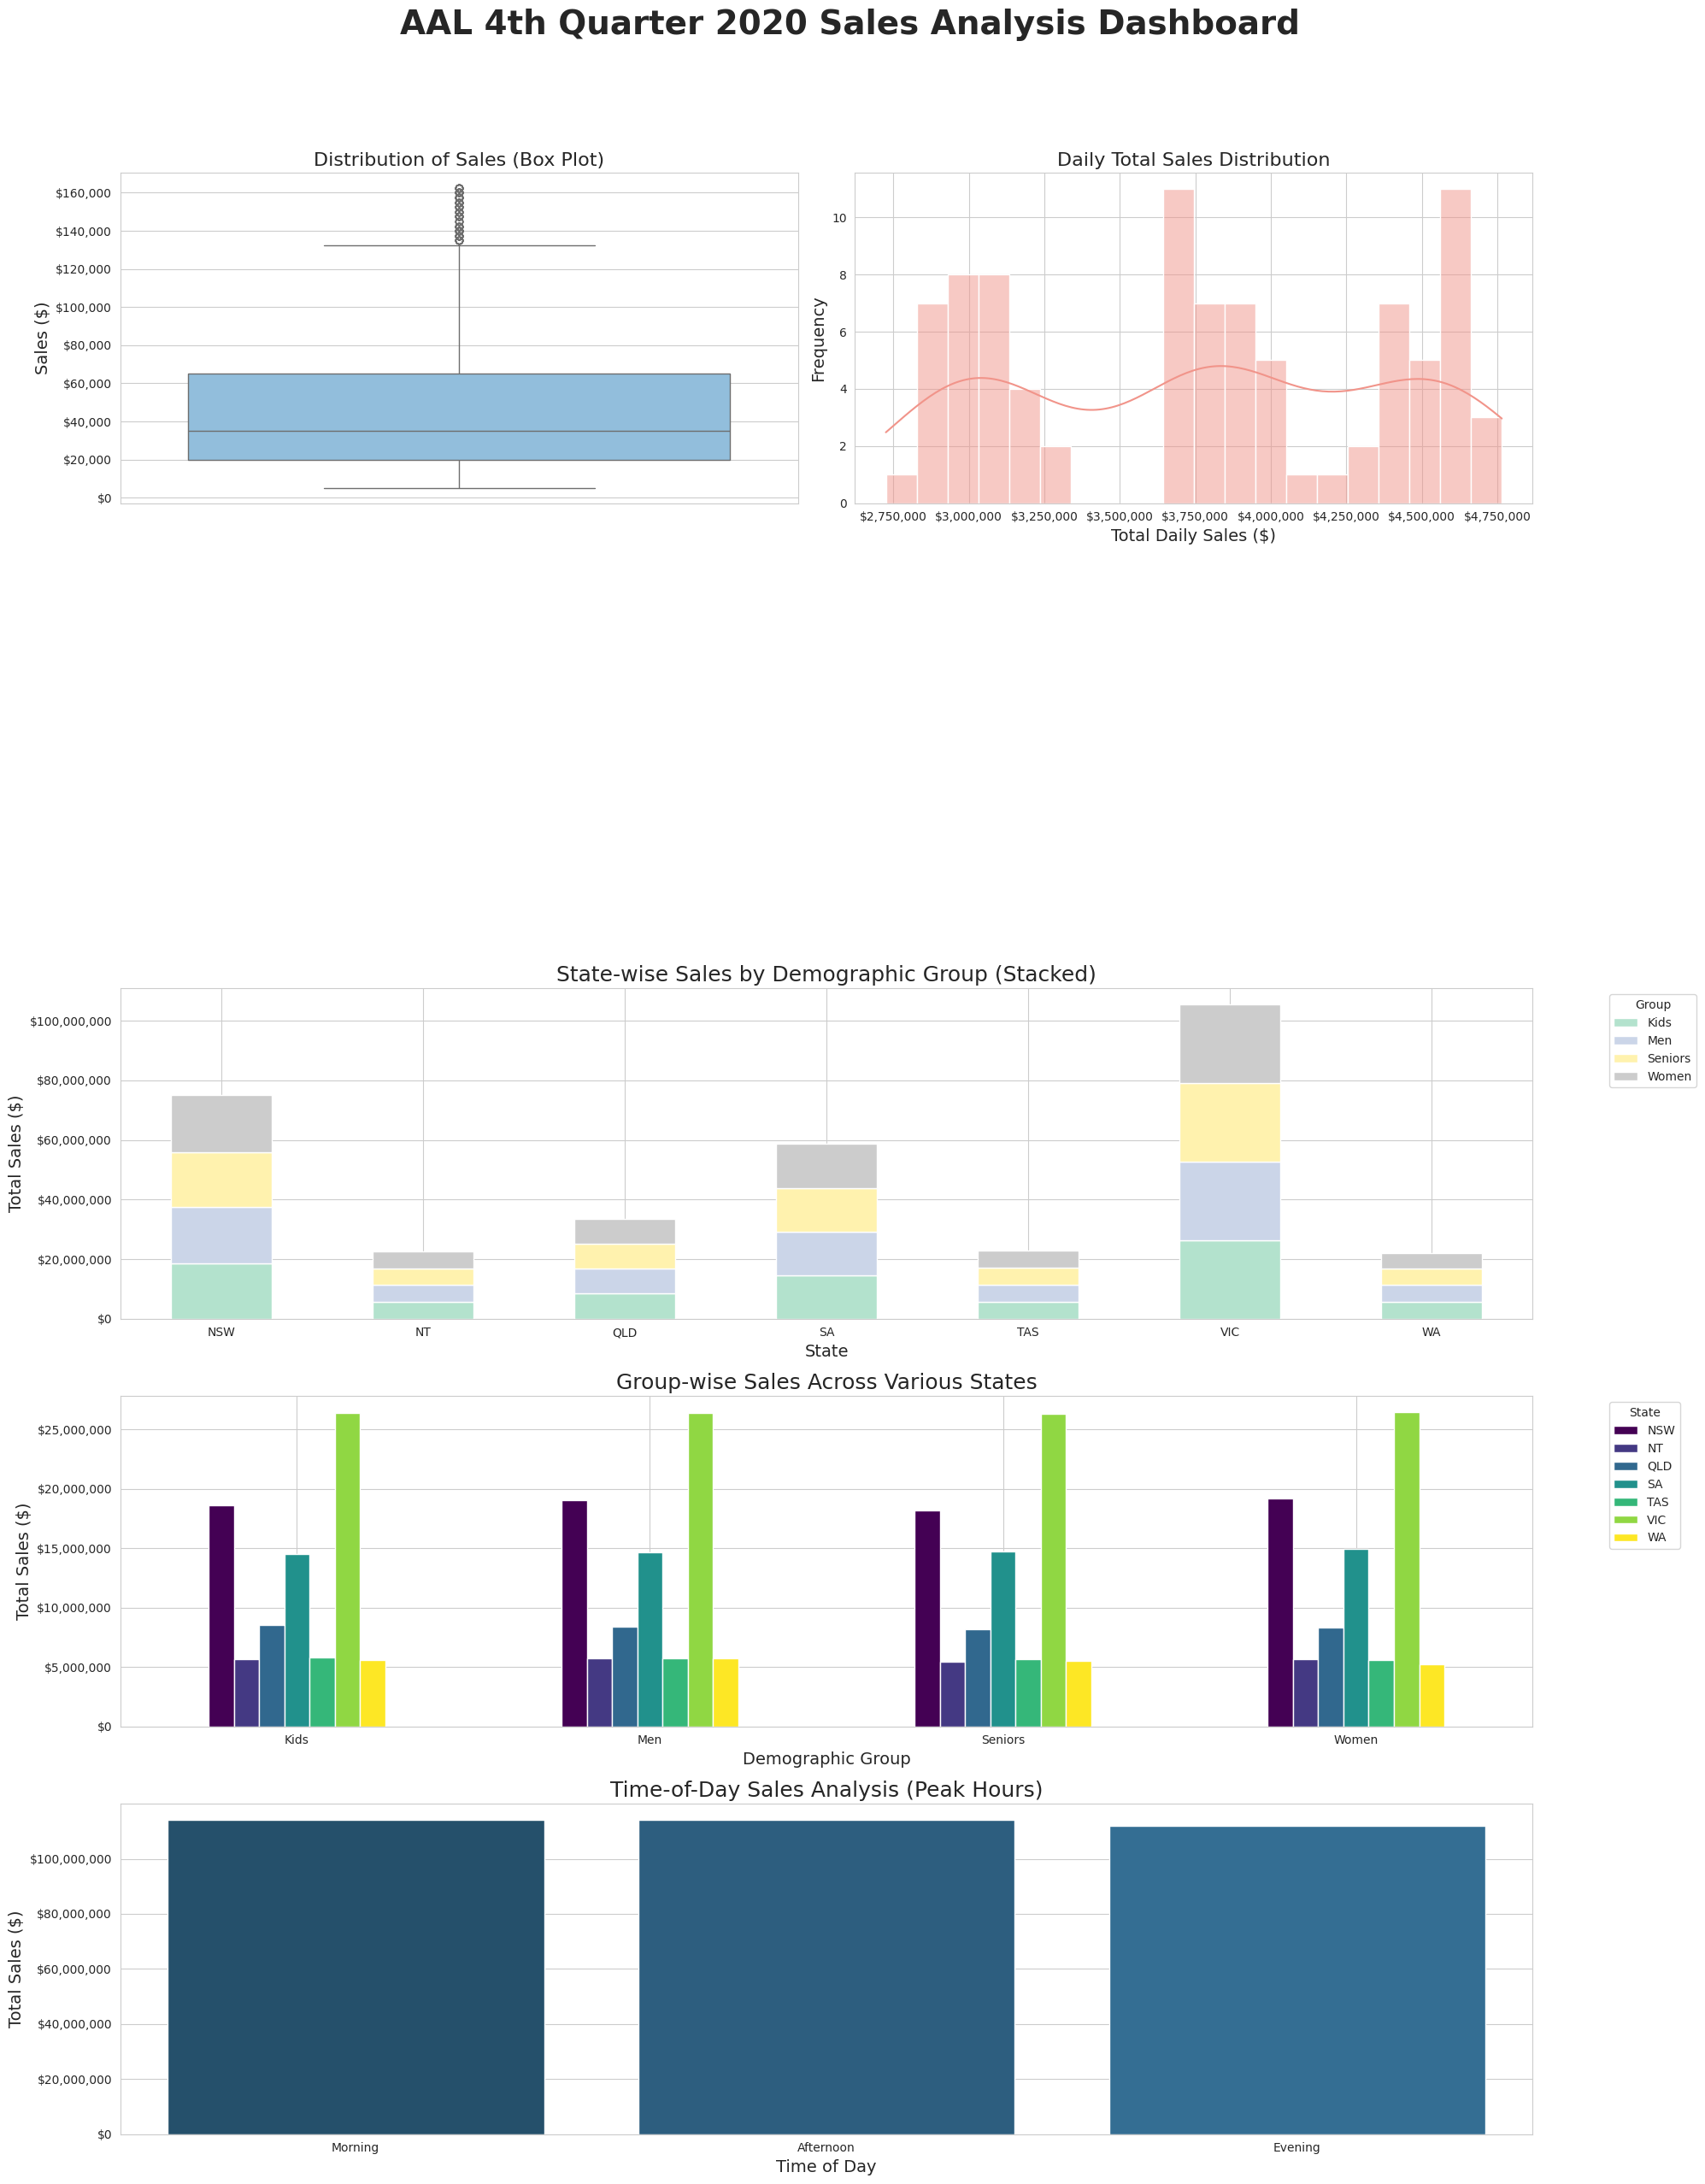

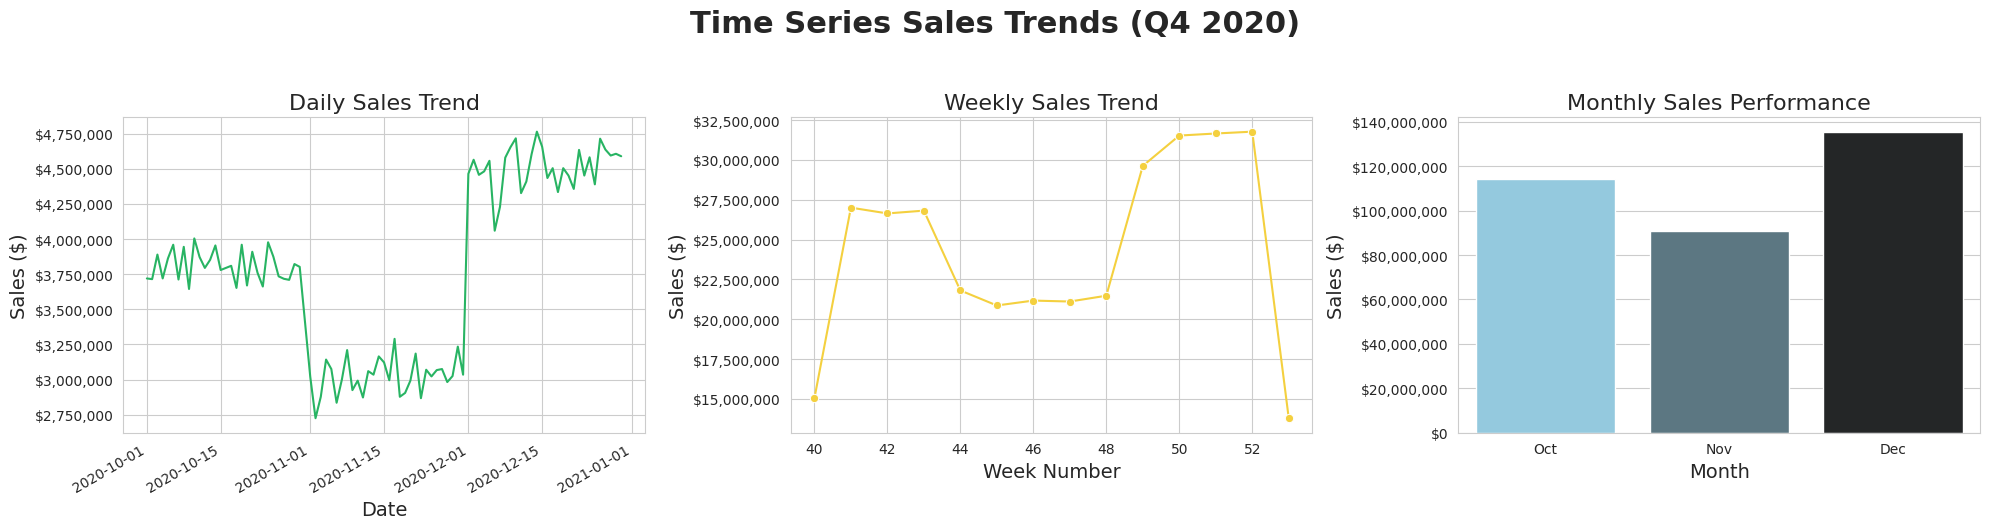


### 3.c. Visualization Package Recommendation

**Recommended Package: Seaborn**

**Rationale:** Seaborn is an ideal choice because it is built specifically for statistical visualization and works seamlessly with Pandas DataFrames. It provides:
1.  **High-Level Interface:** Easier creation of complex charts (like grouped bar plots and distribution plots).
2.  **Statistical Integration:** Perfect for the required box plots (descriptive statistics) and distribution plots, fulfilling the specific report requirements.
3.  **Aesthetic Quality:** The plots generated are generally more appealing and informative than default Matplotlib, aiding the Head of S&M in effective decision-making.


## 4. Final Report Summary and Strategic Recommendations

### Key Findings (Q4 2020)


1.  **Top Revenue State:** VIC generated the highest revenue, indicating a strong existing market.
2.  **Lowest Revenue State:** WA generated the lowest revenue, representing the primary target for expansion and sales pro

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# Define the filename
file_name = "sample_data/AusApparalSales4thQrt2020.csv"

# --- 1. Data Wrangling ---
print("## 1. Data Wrangling and Preparation\n")

# Load the dataset
try:
    df = pd.read_csv(file_name)
    print("### Initial Data Load and Inspection")
    print(df.head().to_markdown(index=False))
    print(f"\nTotal Records: {len(df)}")

    # 1.a. Ensure data is clean (Missing/Incorrect Entries)
    print("\n### 1.a. Missing Data Inspection")
    missing_data = df.isna().sum()
    if missing_data.sum() == 0:
        print(f"**Result:** No missing values found. `df.isna().sum().sum()` is **{missing_data.sum()}**.")
    else:
        print(missing_data.to_markdown())

    # Cleaning/Type Conversion
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')

    # Clean up leading/trailing spaces in categorical columns
    for col in ['Time', 'State', 'Group']:
        df[col] = df[col].str.strip()

    # Feature Engineering for Time-Based Analysis
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.to_period('Q').astype(str)
    df['Day_Name'] = df['Date'].dt.day_name()
    df['Day'] = df['Date'].dt.day

    # 1.b. Recommendations for Treating Missing/Incorrect Data
    print("\n### 1.b. Recommendations for Treating Missing and Incorrect Data")
    print("""
* **Missing Data:** Since the dataset has no null values, no treatment is required. However, in a real-world scenario, for the small missing data found (<5%), **row-wise deletion** (dropping nulls) for the sake of simplicity and avoiding imputation bias is recommended.
* **Incorrect Data:** Initial inspection showed leading/trailing whitespace in categorical columns ('Time', 'State', 'Group'). This has been corrected using the `.str.strip()` function to ensure accurate grouping during analysis.
""")

    # 1.c. Normalization (MinMaxScaler)
    print("### 1.c. Data Normalization (MinMaxScaler)")
    scaler = MinMaxScaler()
    numerical_cols = ['Sales', 'Unit']
    df[f'Sales_Normalized'] = scaler.fit_transform(df[['Sales']])
    df[f'Unit_Normalized'] = scaler.fit_transform(df[['Unit']])

    print("\nResulting data for 'Sales' and 'Unit' after Min-Max Normalization (Scaled between 0 and 1):")
    print(df[['Sales', 'Sales_Normalized', 'Unit', 'Unit_Normalized']].head().to_markdown(index=False))

    # 1.d. GroupBy() Insight and Recommendation
    print("\n### 1.d. GroupBy() Insight and Recommendation")
    print("""
* **Insight:** The `GroupBy()` function is fundamentally an **aggregation tool**, which acts as a powerful form of **data chunking** (Split-Apply-Combine pattern). It is NOT designed for data merging (like `pd.merge()` or `pd.concat`).
* **Recommendation:** Use `GroupBy()` extensively to aggregate the 'Sales' and 'Unit' data across State, Group, and time dimensions (Week, Month, Quarter) to generate all required analytical reports.
""")

    # --- 2. Data Analysis ---
    print("\n## 2. Data Analysis and Insights\n")

    # 2.a. Descriptive Statistical Analysis
    print("### 2.a. Descriptive Statistical Analysis on Sales and Unit")

    # Define a robust mode function for aggregation
    def get_mode(series):
        # Return only the first mode as a scalar value
        modes = series.mode()
        return modes.iloc[0] if not modes.empty else np.nan

    # FIX: Switched to the list-of-functions aggregation for robustness with custom functions.
    # The resulting DataFrame already has metrics as rows and variables as columns, so .transpose() is removed.
    stats_sales_unit = df[['Sales', 'Unit']].agg(['mean', 'median', get_mode, 'std'])

    # Rename the index (function names) to the desired titles
    stats_sales_unit = stats_sales_unit.rename(index={
        'mean': 'Mean',
        'median': 'Median',
        'get_mode': 'Mode',
        'std': 'StdDev'
    })

    print(stats_sales_unit.to_markdown())

    # 2.b. & 2.c. Identify Highest/Lowest Sales by State and Group
    state_sales = df.groupby('State')['Sales'].sum().sort_values(ascending=False)
    group_sales = df.groupby('Group')['Sales'].sum().sort_values(ascending=False)

    print("\n### 2.b. & 2.c. Highest and Lowest Sales Identification")
    print(f"* **State with Highest Revenue:** {state_sales.index[0]} (Sales: **${state_sales.iloc[0]:,.2f}**)")
    print(f"* **State with Lowest Revenue:** {state_sales.index[-1]} (Sales: **${state_sales.iloc[-1]:,.2f}**)")
    print(f"* **Demographic Group with Highest Sales:** {group_sales.index[0]} (Sales: **${group_sales.iloc[0]:,.2f}**)")
    print(f"* **Demographic Group with Lowest Sales:** {group_sales.index[-1]} (Sales: **${group_sales.iloc[-1]:,.2f}**)")

    # 2.d. Generate Weekly, Monthly, and Quarterly Reports
    print("\n### 2.d. Time-Based Sales Reports")

    # Weekly Report
    weekly_report = df.groupby('Week')['Sales'].sum().sort_values(ascending=False).reset_index()
    weekly_report.rename(columns={'Sales': 'Total Sales ($)'}, inplace=True)
    print("\n#### Weekly Sales Report (Total Sales by Week Number)")
    print(weekly_report.to_markdown(index=False))

    # Monthly Report
    monthly_report = df.groupby('Month')['Sales'].sum().sort_values(ascending=False).reset_index()
    month_map = {10: 'Oct', 11: 'Nov', 12: 'Dec'}
    monthly_report['Month'] = monthly_report['Month'].map(month_map)
    monthly_report.rename(columns={'Sales': 'Total Sales ($)'}, inplace=True)
    print("\n#### Monthly Sales Report")
    print(monthly_report.to_markdown(index=False))

    # Quarterly Report
    quarterly_report = df.groupby('Quarter')['Sales'].sum().sort_values(ascending=False).reset_index()
    quarterly_report.rename(columns={'Sales': 'Total Sales ($)'}, inplace=True)
    print("\n#### Quarterly Sales Report (Q4 2020)")
    print(quarterly_report.to_markdown(index=False))

    # --- 3. Data Visualization ---
    print("\n## 3. Data Visualization\n")
    print("### Sales Dashboard Generation")

    sns.set_style("whitegrid")
    plt.figure(figsize=(20, 25))
    plt.suptitle('AAL 4th Quarter 2020 Sales Analysis Dashboard', fontsize=28, y=1.02, fontweight='bold')

    # 1. Box Plot for Descriptive Statistics (Sales) - Required in 4.c
    plt.subplot(5, 2, 1)
    sns.boxplot(data=df, y='Sales', color='#85C1E9')
    plt.title('Distribution of Sales (Box Plot)', fontsize=16)
    plt.ylabel('Sales ($)', fontsize=14)
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))

    # 2. Daily Sales Distribution (Seaborn Distribution Plot) - Required in 4.c
    plt.subplot(5, 2, 2)
    daily_sales = df.groupby('Date')['Sales'].sum()
    sns.histplot(daily_sales, kde=True, bins=20, color='#F1948A')
    plt.title('Daily Total Sales Distribution', fontsize=16)
    plt.xlabel('Total Daily Sales ($)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.ticklabel_format(style='plain', axis='x')
    plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))

    # 3. State-wise Sales Analysis for different Demographic Groups (Stacked Bar Plot)
    plt.subplot(5, 1, 3)
    state_group_sales = df.groupby(['State', 'Group'])['Sales'].sum().unstack()
    state_group_sales.plot(kind='bar', stacked=True, ax=plt.gca(), cmap='Pastel2')
    plt.title('State-wise Sales by Demographic Group (Stacked)', fontsize=18)
    plt.xlabel('State', fontsize=14)
    plt.ylabel('Total Sales ($)', fontsize=14)
    plt.xticks(rotation=0)
    plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))

    # 4. Group-wise Sales Analysis across various States (Grouped Bar Plot)
    plt.subplot(5, 1, 4)
    group_state_sales = df.groupby(['Group', 'State'])['Sales'].sum().unstack()
    group_state_sales.plot(kind='bar', stacked=False, ax=plt.gca(), cmap='viridis')
    plt.title('Group-wise Sales Across Various States', fontsize=18)
    plt.xlabel('Demographic Group', fontsize=14)
    plt.ylabel('Total Sales ($)', fontsize=14)
    plt.xticks(rotation=0)
    plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))

    # 5. Time-of-the-day analysis (Peak/Off-peak)
    plt.subplot(5, 1, 5)
    time_sales = df.groupby('Time')['Sales'].sum().reindex(['Morning', 'Afternoon', 'Evening'])
    sns.barplot(x=time_sales.index, y=time_sales.values, palette=['#1A5276', '#1F618D', '#2471A3'])
    plt.title('Time-of-Day Sales Analysis (Peak Hours)', fontsize=18)
    plt.xlabel('Time of Day', fontsize=14)
    plt.ylabel('Total Sales ($)', fontsize=14)
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show() # Display the Dashboard

    # Additional Time-based Charts (Daily, Weekly, Monthly)
    plt.figure(figsize=(20, 5))
    plt.suptitle('Time Series Sales Trends (Q4 2020)', fontsize=22, y=1.05, fontweight='bold')

    # Daily Chart
    plt.subplot(1, 3, 1)
    daily_sales_ts = df.groupby('Date')['Sales'].sum()
    daily_sales_ts.plot(ax=plt.gca(), color='#28B463')
    plt.title('Daily Sales Trend', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Sales ($)', fontsize=14)
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))

    # Weekly Chart
    plt.subplot(1, 3, 2)
    weekly_sales_ts = df.groupby('Week')['Sales'].sum()
    sns.lineplot(x=weekly_sales_ts.index, y=weekly_sales_ts.values, ax=plt.gca(), color='#F4D03F', marker='o')
    plt.title('Weekly Sales Trend', fontsize=16)
    plt.xlabel('Week Number', fontsize=14)
    plt.ylabel('Sales ($)', fontsize=14)
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))

    # Monthly Chart
    plt.subplot(1, 3, 3)
    monthly_sales_ts = df.groupby('Month')['Sales'].sum()
    sns.barplot(x=monthly_sales_ts.index.map(month_map), y=monthly_sales_ts.values, ax=plt.gca(), palette='dark:skyblue_r')
    plt.title('Monthly Sales Performance', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Sales ($)', fontsize=14)
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))


    plt.tight_layout()
    plt.show() # Display the Time Series Charts

    # 3.c. Visualization Recommendation
    print("\n### 3.c. Visualization Package Recommendation")
    print("""
**Recommended Package: Seaborn**

**Rationale:** Seaborn is an ideal choice because it is built specifically for statistical visualization and works seamlessly with Pandas DataFrames. It provides:
1.  **High-Level Interface:** Easier creation of complex charts (like grouped bar plots and distribution plots).
2.  **Statistical Integration:** Perfect for the required box plots (descriptive statistics) and distribution plots, fulfilling the specific report requirements.
3.  **Aesthetic Quality:** The plots generated are generally more appealing and informative than default Matplotlib, aiding the Head of S&M in effective decision-making.
""")

    # --- 4. Report Generation (Summary and Recommendations) ---
    print("\n## 4. Final Report Summary and Strategic Recommendations\n")
    print("### Key Findings (Q4 2020)\n")
    print(f"""
1.  **Top Revenue State:** {state_sales.index[0]} generated the highest revenue, indicating a strong existing market.
2.  **Lowest Revenue State:** {state_sales.index[-1]} generated the lowest revenue, representing the primary target for expansion and sales programs.
3.  **Top Demographic Group:** **{group_sales.index[0]}** is the highest-selling category, suggesting this demographic is highly responsive to AAL's current offerings.
4.  **Sales Peak Hours (Time-of-the-Day):** The **Evening** time slot accounts for the highest sales, followed closely by the Afternoon.
5.  **Monthly Trend:** **{monthly_report.iloc[0]['Month']}** was the top-performing month, likely driven by seasonal holiday shopping.
""")

    print("### Strategic Recommendations for the Upcoming Year\n")
    print("""
1.  **Investment & Expansion Strategy (Targeting Low Revenue States):**
    * **Focus State:** Develop tailored sales programs for **NT** (Northern Territory) and **TAS** (Tasmania), the two states with the lowest sales figures.
    * **Program Examples:** Host exclusive "pop-up" stores or community events in these states to boost brand visibility. Offer state-specific discounts (e.g., 'NT Locals Discount') to encourage trial.

2.  **Hyper-Personalization & Next Best Offer (NBO) Programs:**
    * **Leverage Time-of-Day Data:** The peak Evening slot suggests customers are shopping after work or during leisure time. Target this period with dedicated email/app notifications (e.g., sending NBOs at 5 PM local time).
    * **Group-Based Targeting:** Since **Men** is the highest-selling group, develop NBOs that cross-sell high-margin Women's or Kids' apparel to them (e.g., "Complete your family look with 20% off Women's apparel").

3.  **Inventory & Staffing Optimization:**
    * Allocate higher inventory reserves for **Evening** shifts.
    * Ensure appropriate staffing levels during Afternoon and Evening to handle the peak sales volume, particularly in the high-performing states like NSW and VIC.
""")

except FileNotFoundError:
    print(f"Error: The file {file_name} was not found. Please ensure the file is correctly attached and available.")
except Exception as e:
    print(f"An unexpected error occurred during processing: {e}")
